In [1]:
import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage, Compose, Lambda
from PIL import Image
import os
from tqdm import tqdm

from diffusion_model import UNet
from train import (
    TIMESTEPS, betas, alphas, alphas_cumprod, sqrt_recip_alphas,
    sqrt_one_minus_alphas_cumprod, posterior_variance
)

# --- Configuration ---
MODEL_PATH = 'diffusion_upscaler.pth'
INPUT_IMAGE_PATH = 'data/test/test_image.png'
OUTPUT_IMAGE_PATH = 'output/upscaled_diffusion.png'
UPSCALE_FACTOR = 2
TARGET_HR_SIZE = 64 # Must match training IMG_SIZE
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

2025-10-03 08:26:09.833883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759479969.846515   67711 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759479969.850386   67711 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-03 08:26:09.862347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

betas = betas.to(DEVICE)
sqrt_recip_alphas = sqrt_recip_alphas.to(DEVICE)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(DEVICE)
posterior_variance = posterior_variance.to(DEVICE)


# --- Sampling Function ---
@torch.no_grad()
def p_sample(model, x, t, t_index, low_res_img):
    # Use the imported and device-synced betas tensor
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the DDPM paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, low_res_img) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape, low_res_img):
    device = next(model.parameters()).device
    b = shape[0]
    img = torch.randn(shape, device=device) # Start with pure noise
    imgs = []

    for i in tqdm(reversed(range(0, TIMESTEPS)), desc='Sampling loop', total=TIMESTEPS):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, low_res_img)
        # Optional: save intermediate images
        # if i % 50 == 0:
        #     imgs.append(img.cpu())
    return img

In [8]:
# --- Main Inference ---
def upscale_image(input_img):
    # Correct the normalization to match the training range [-1, 1]
    transform = Compose([
        ToTensor(), # Scales to [0, 1]
        Lambda(lambda t: (t * 2) - 1) # Scale to [-1, 1]
    ])
    low_res_tensor = transform(input_img).unsqueeze(0).to(DEVICE)

    # Run the diffusion sampling process
    print("Starting diffusion sampling...")
    output_tensor = p_sample_loop(model, 
                                  shape=(1, 3, TARGET_HR_SIZE, TARGET_HR_SIZE), 
                                  low_res_img=low_res_tensor)

    # De-normalize from [-1, 1] back to [0, 1]
    output_tensor = (output_tensor.clamp(-1, 1) + 1) / 2
    to_pil = ToPILImage()
    return to_pil(output_tensor.squeeze(0).cpu())

def load_img_file(image_path):
    if not os.path.exists(image_path):
        print(f"Input image not found: {image_path}")
        return

    return Image.open(image_path).convert('RGB')

def load_model(model):
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        model.eval()
    except FileNotFoundError:
        print(f"Model file not found at {MODEL_PATH}. Please run train.py first.")
        return

In [20]:
original_img = load_img_file(INPUT_IMAGE_PATH)

model = UNet().to(DEVICE)
load_model(model)

# For inference, the input image is the low-resolution one
# So we resize it to the expected low-res size
lr_w, lr_h = TARGET_HR_SIZE // UPSCALE_FACTOR, TARGET_HR_SIZE // UPSCALE_FACTOR
original_img_downscaled = original_img.resize((TARGET_HR_SIZE, TARGET_HR_SIZE), Image.BICUBIC)
low_res_pil = original_img.resize((lr_w, lr_h), Image.BICUBIC)

# Upscale with bicubic for conditioning and comparison
bicubic_upscaled = low_res_pil.resize((TARGET_HR_SIZE, TARGET_HR_SIZE), Image.BICUBIC)

output_img = upscale_image(bicubic_upscaled)

Starting diffusion sampling...


Sampling loop: 100%|██████████| 1000/1000 [00:05<00:00, 167.66it/s]


Original High Res Image
(2040, 1404)


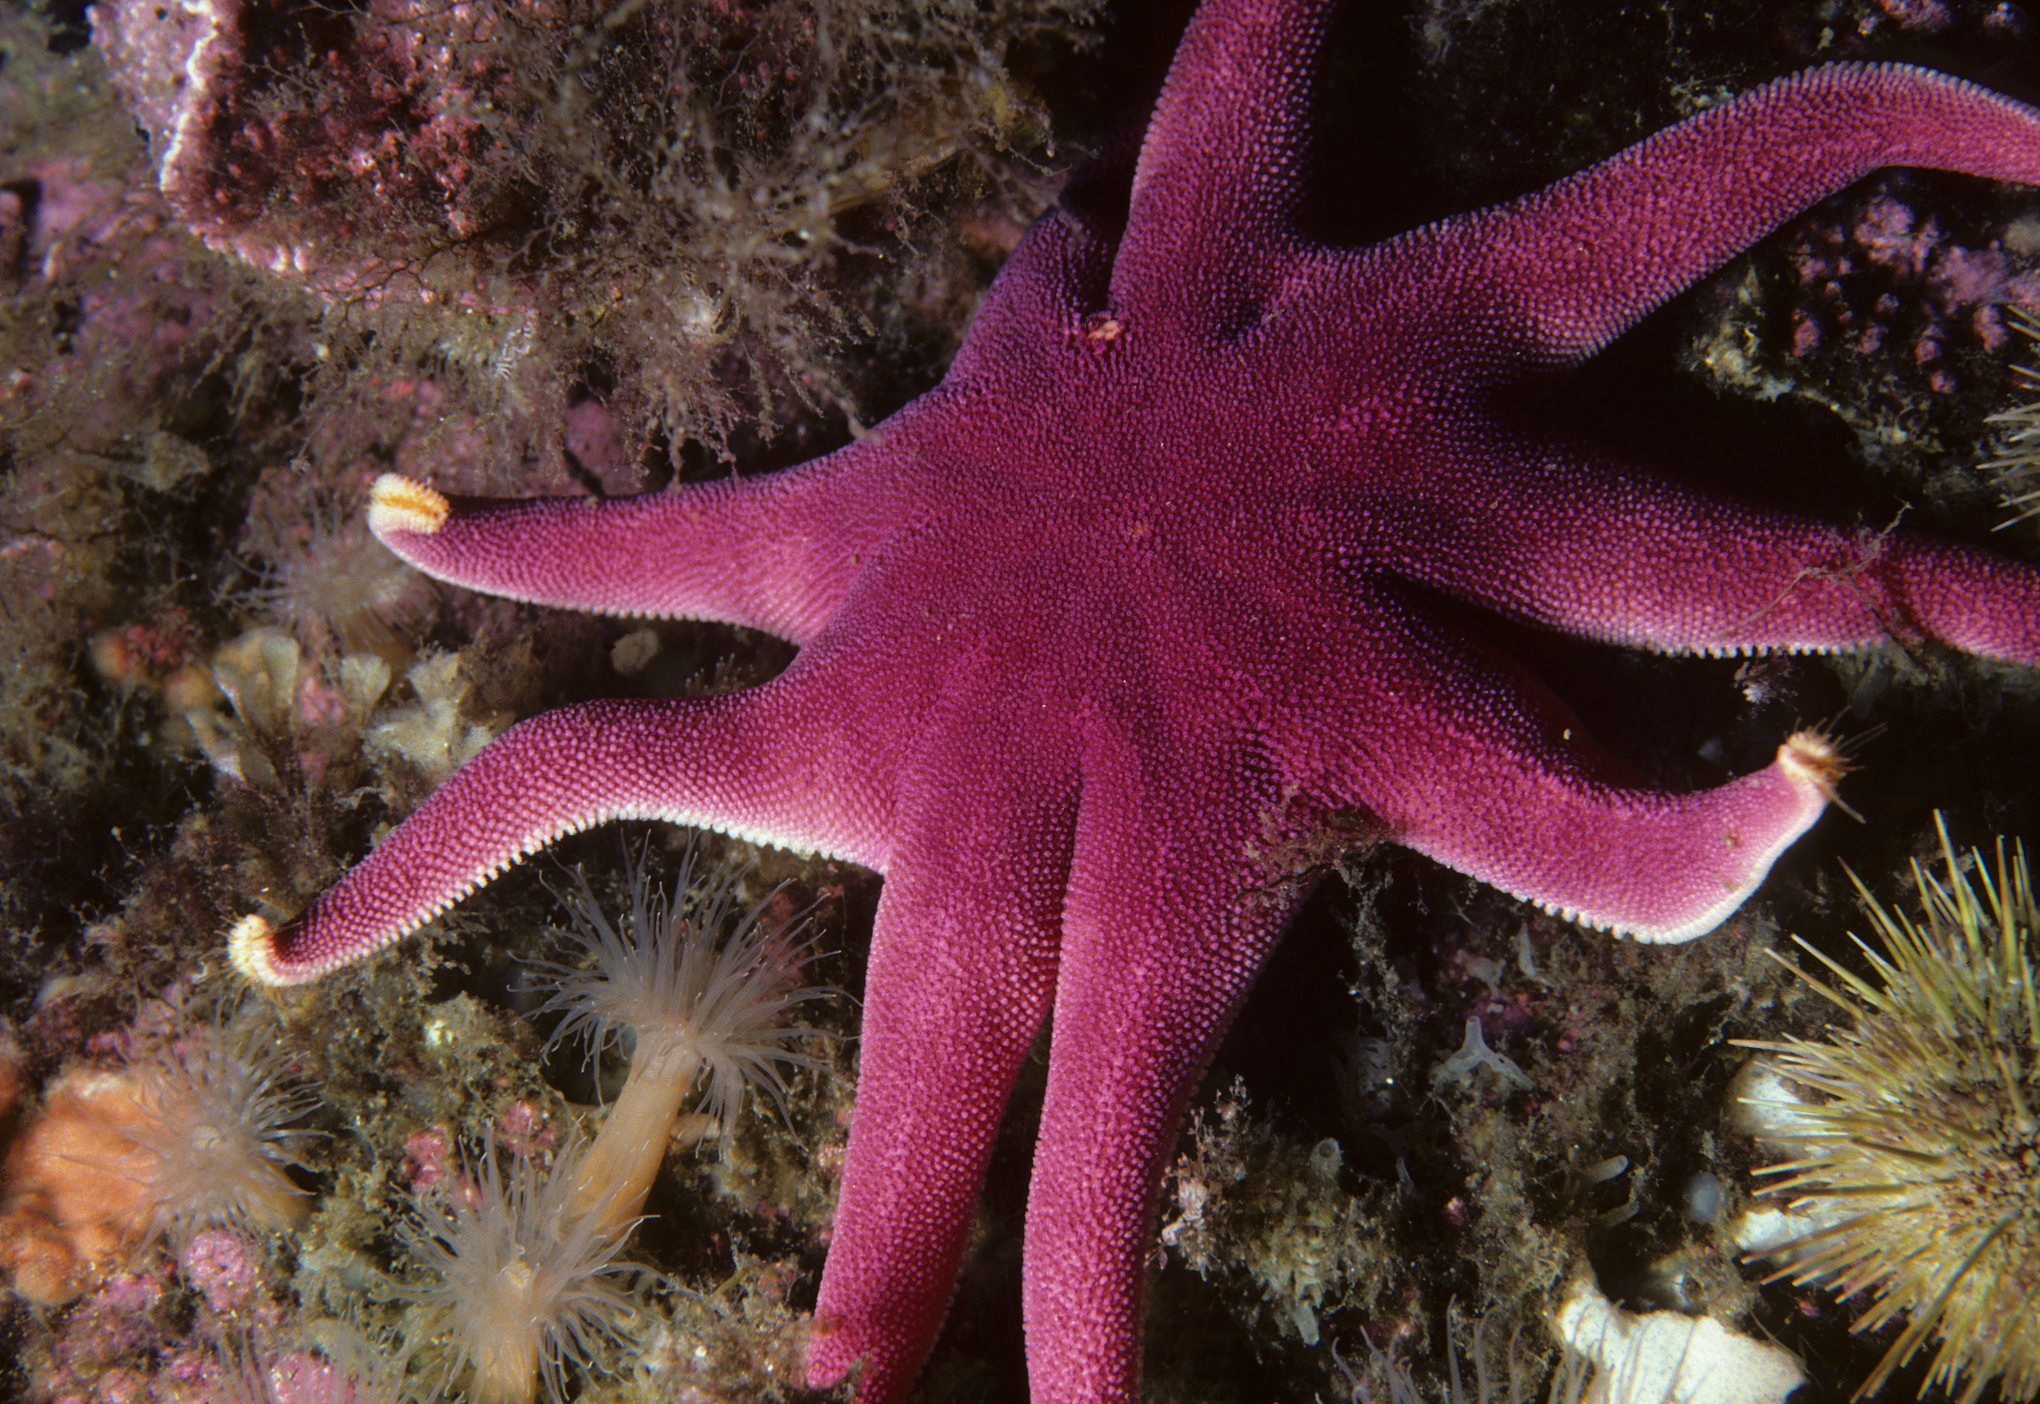

In [21]:
print("Original High Res Image")
print(original_img.size)
original_img

Downscaled original image:
(64, 64)


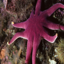

In [22]:
print("Downscaled original image:")
print(original_img_downscaled.size)
original_img_downscaled

Bicubic upscaled image output:
(64, 64)


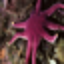

In [18]:
print("Bicubic upscaled image output:")
print(bicubic_upscaled.size)
bicubic_upscaled

Unet upscaled output:
(64, 64)


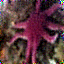

In [19]:
print("Unet upscaled output:")
print(output_img.size)
output_img

(32, 32)


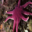